# Introduction

From [Human Primay T Cells: A Practical Guide](https://docs.google.com/document/d/1LIuLDXPm1L3KvsZwtrhaZtiUjZ3i3y74uN_FcEM-gqk/edit#heading=h.pxrhs3yh98tg):
> Short- and long-term culturing of the T cells for research or clinical purposes rely on continuous expansion of these cells. Without activation, T cells do not proliferate efficiently and on top of that, their inactive profile makes them harder to manipulate and profile. Commonly used activation techniques are similar to each other in principle but the specific method used for T cell activation can enrich certain T subsets. Anti-CD3- and anti-CD28-based activation is the most commonly used technique in both research and clinical settings. Since this method is not antigen-specific, it does not lead to rapid clonal expansion but instead helps maintain the proliferation of a diverse set of T cells.

and [the number of beads used for activation can be optimized againist cost/efficiency](https://docs.google.com/document/d/1LIuLDXPm1L3KvsZwtrhaZtiUjZ3i3y74uN_FcEM-gqk/edit#heading=h.rbaq026yb3fn):
> As expected, the yield from the recommended bead-to-cell ratio of 1:1 was the highest but surprisingly use of half of recommended beads (that is at 1:2 bead-to-cell ratio) did not compromise the final yield. 1:4 or lower bead-to-cell ratios monotonically decreased the overall yield where at 1:2048 ratio, we observed the minimal cell growth. When we checked the CD4 and CD8 positive population frequencies upon activating the cells with the recommended (1:1) or lower (1:2-1:8) concentration of beads, we did not detect any significant changes. However, when lower concentration of activation beads were used, the early activation marker CD69 level (MFI) detected by flow cytometry was also lower. 

Here are [the titration curves across two donors](https://github.com/hammerlab/t-cell-guide/blob/master/analyses/activation-bead-titration/Activation%20bead%20titration%20results%20via%20flow%20and%20count.ipynb), for reference:
<a href="https://cl.ly/1bc84e8d7ea8" target="_blank"><img src="https://d2ddoduugvun08.cloudfront.net/items/0n2i37253L2q1m2j0L1p/Image%202019-01-09%20at%2010.53.15%20AM.png" style="display: block; height: auto;width: 50%;"/></a>

So far so good but we want to have a model representing this system so that we can play with the conditions and decide on the best and the most efficienct way to activate cells. We also want to have an idea about what happens to a population of cells when activated in a different manner.

In [1]:
# Let's load all the libraries we will be needing

library('magrittr')
library('tibble')
library('dplyr')
library('tidyr')
library('ggplot2')
library('RColorBrewer')
library('readr')

# and make this reproducible to a degree
set.seed(201901)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



# Modeling

## The distribution of cells and beads within a culture environment
Let's start with the vessel we culture these cells.

We commonly use one of these multi-well systems:
- 96-well (0.32 cm$^2$ per well)
- 24-well (2 cm$^2$ per well)
- 12-well (4 cm$^2$ per well)
- 6-well  (9 cm$^2$ per well)


Here are some diameter values for beads and cells:
- Dynabeads: 4.5 um
- Unstimulated T cells: ~9 um
- Activated T cells: ~13 um

Although considered suspension cells, primary T cells barely "swim" and they usually end up sinking to the bottom of the cell after an hour following seeding. Also, unstimulated cells do not express/have the cellular mechanisms hat are required to actively move around so they can virtually be considered passive.

Let's do a back-of-the-envelope calculation and grossly round up numbers for convenience. For our thought experiment, both cells and beads will be considered as uniform spheres, which luckily they are, with 10-um diameter. To make things even easier, we will just assume they are like cubes that up 2D or 3D space. With this, a single 96-well (0.32 cm$^2$) would allow 320000 (0.32 cm$^2$ / (10 um)$^2$) objects to fit in. We will consider this as our 100% confluency. So a confluency of 50% would mean we will be using only half of the slots within the vessel and the rest of the slots will be considered empty.

Here is how it looks when you put 160K cells and 160K beads within a 96-well plate:
<a href="https://cl.ly/a4177b31f810" target="_blank"><img src="https://d2ddoduugvun08.cloudfront.net/items/3N171v2Y1J371G2Z0i0s/Image%202019-01-09%20at%201.46.45%20PM.png"/></a>

With the beads, it looks relatively more crowded and they are not perfectly uniformly distributed but our rough estimation doesn't look completely unrealistic. If we keep these cells together with the beads long enough (>12 hours), then they start to form clusters and they lose their uniform distribution. For the sake of our argument, we don't need to think about the clustering as we are mostly interested in the initial contact (early time points after seeding).


With that said, let's try to simulate this in silico. Assume that our virtual plate is 10-by-10 so it has a total of 100 slots. Each cell can be only one of the following:

- `B`: bead
- `C`: cell
- `.`: empty

We can decide how many of these slots we will be using when creating a virtual plate but the assignments will be completely random. For example, at 80% confluency (80 slots) and 1:1 bead-to-cell ratio, we will have 20 empty slots, 40 beads, and 40 cells:

In [2]:
side_size <- 10 # 10 * 10
num_of_cells <- 40
num_of_beads <- 40
num_of_empty <- (side_size ** 2) - (num_of_cells + num_of_beads)

m_base <- c(
    rep('B', num_of_beads),
    rep('C', num_of_cells),
    rep('.', num_of_empty)
)

m <- matrix(base::sample(m_base), nrow=side_size)
m

C,.,B,.,B,C,B,B,.,B
C,C,B,C,C,C,.,C,B,C
C,C,C,C,C,B,B,B,C,B
B,.,.,C,.,C,C,C,C,C
C,.,C,B,.,B,.,B,B,C
B,C,C,B,.,C,B,C,B,C
C,C,B,C,B,B,B,B,.,.
B,C,B,.,B,B,.,B,.,C
C,B,.,B,B,C,C,B,C,B
B,B,.,B,.,C,B,B,.,C


Here is another one, ~75% confluency 1:2 bead-to-cell ratio:

In [3]:
side_size <- 10 # 10 * 10
num_of_cells <- 50
num_of_beads <- 25
num_of_empty <- (side_size ** 2) - (num_of_cells + num_of_beads)

m_base <- c(
    rep('B', num_of_beads),
    rep('C', num_of_cells),
    rep('.', num_of_empty)
)

m <- matrix(base::sample(m_base), nrow=side_size)
m

C,C,B,B,C,C,C,C,C,C
.,.,B,.,B,B,C,C,C,C
C,C,.,B,C,.,B,C,.,B
C,B,C,C,C,C,.,.,C,B
C,C,B,C,B,.,C,B,C,.
.,C,B,C,C,B,C,.,.,C
.,.,C,B,C,B,C,.,B,.
C,B,B,C,C,C,B,.,C,C
C,C,B,C,.,.,C,.,C,B
.,.,C,C,.,B,C,.,C,B


In [26]:
side_size <- 10 # 10 * 10
num_of_cells <- 1
num_of_beads <- 9
num_of_empty <- (side_size ** 2) - (num_of_cells + num_of_beads)

m_base <- c(
    rep('B', num_of_beads),
    rep('C', num_of_cells),
    rep('.', num_of_empty)
)

m <- matrix(base::sample(m_base), nrow=side_size)
m

.,.,.,.,.,.,.,.,.,.
.,.,.,.,.,.,.,B,.,.
.,.,.,.,.,B,.,.,.,C
.,.,.,.,.,B,B,.,.,.
.,.,.,.,.,.,.,.,.,.
.,.,.,.,.,.,.,B,.,.
.,.,.,.,.,.,B,.,.,.
.,.,.,.,.,.,.,.,.,.
.,.,.,.,.,.,.,.,.,.
B,B,.,.,.,.,B,.,.,.


## Deciding the activation conditions
And once we have a plate like this, we can then say which cell gets activated with a very simple rule:

> If a cell (`C`) is nearby a bead (`B`), it gets activated.

Note that bead-based activation also works in a similar way. A cell can bind to multiple beads at a time, but they need to be in physical contact for a successful activation. The binding of the cell to the bead is somewhat weak so rigourous mixing of the cell-bead mixture is usually enough to dissociate them. Therefore, once we seed the cells with the beads and they settle down, they are either next to a bead or not. And since they cannot move on their own and there is little dynamic drift in the culture, we don't expect them to pair up with beads after a while under normal circumstances.

Let's create a function that counts the beads next to cells:

In [4]:
count_near_beads <- function(m, i, j) {
    nhood <- c()
    if(i > 1) {
        nhood <- c(nhood, m[i-1, j])
    }
    
    if(j > 1) {
        nhood <- c(nhood, m[i, j-1])
    }
    
    if(i > 1 && j > 1) {
        nhood <- c(nhood, m[i-1, j-1])
    }
    
    if(i < nrow(m)) {
        nhood <- c(nhood, m[i+1, j])
    }
    
    if(j < ncol(m)) {
        nhood <- c(nhood, m[i, j+1])
    }
    
    if(i < nrow(m) && j < ncol(m)) {
        nhood <- c(nhood, m[i+1, j+1])
    }
    
    if(i > 1 && j < ncol(m)) {
        nhood <- c(nhood, m[i-1, j+1])
    }
    
    if(i < nrow(m) && j > 1) {
        nhood <- c(nhood, m[i+1, j-1])
    }

    sum(nhood == 'B')
}

count_near_beads(m, 1, 1)
count_near_beads(m, 10, 10)
count_near_beads(m, 1, 10)
count_near_beads(m, 10, 1)
count_near_beads(m, 10, 5)
count_near_beads(m, 5, 10)
count_near_beads(m, 5, 5)

[1] 0

[1] 1

[1] 0

[1] 0

[1] 1

[1] 1

[1] 1

Now, we can ask how many cells are near-by at least one bead:

In [5]:
near_beads <- 
    which(m == 'C', arr.ind=TRUE) %>%
    apply(MARGIN=1, FUN=function(x) { count_near_beads(m, x[1], x[2]) } )

sum(near_beads > 0)

[1] 46

This is 43 out of 50 cells so 86% of them. These are the ones we will consider as activated. Let's wrap this logic in a tidy function so we can repeatedly simulate this and see the effects of different conditions on the percent of cells getting activated:

In [6]:
simulate_bead_activation <- function(side_size, n_cells, n_beads) {
    slots <- side_size ** 2
    n_empty <- slots - (n_cells + n_beads)
    m_base <- c(
        rep('B', n_beads),
        rep('C', n_cells),
        rep('0', n_empty)
    )
    m <- matrix(base::sample(m_base), nrow=side_size)
    
    near_beads <- 
        which(m == 'C', arr.ind=TRUE) %>%
        apply(MARGIN=1, FUN=function(x) { count_near_beads(m, x[1], x[2]) } )
    n_nearbead_cells <- sum(near_beads > 0)
    
    return(n_nearbead_cells)
}

In [7]:
# Almost all of the cells should be near a bead.
simulate_bead_activation(side_size=100, n_cells=5000, n_beads=5000)

[1] 4980

In [8]:
# No cells should be near a bead as there are no bead
simulate_bead_activation(side_size=100, n_cells=5000, n_beads=0)

[1] 0

In [9]:
# depending on the bead location, we expect 3-8 cells to be near that single bead
simulate_bead_activation(side_size=100, n_cells=9999, n_beads=1)

[1] 8

In [10]:
# this time, 6-16 as we have two beads:
simulate_bead_activation(side_size=100, n_cells=9998, n_beads=2)

[1] 16

In [11]:
# see how long it takes to simulate a 100-by-100 board (for reference)
system.time({ simulate_bead_activation(side_size=100, n_cells=9998, n_beads=2) })

   user  system elapsed 
  0.412   0.003   0.416 

## Simulating different conditions
Now that we can simulate, we will start changing the conditions and see how they change things. We will run 100 simulations within a 50-by-50 plate for each condition and we will permute the following conditions every time:

- Bead to cell ratio: 3, 1, .3, .1, .03, .01, 0.003, and 0 (no beads)
- Confluencies: 100%, 50%, 25%, and 12.5%

We are doing this, because there is a huge difference between putting 1 cell together with 1 bead within a plate and 100K cells together with 100K beads, where for the former, the chances of the cell ending up near a bead is much much smaller.

This might take a while:

In [12]:
n_simulations <- 100
side_size <- 50
n_slots <- side_size ** 2
bead_to_cell_ratios <- c(3, 1, .3, .1, .03, .01, 0.003, 0)
confluencies <- c(1, .5, .25, .125)

sim_results <- c(NULL)

for(confluency in confluencies) {
    for(bead_to_cell_ratio in bead_to_cell_ratios) {
        for(n_sim in 1:n_simulations) {
            filled_slots <- as.integer(n_slots * confluency)
            n_cells <- as.integer(filled_slots / (1 + bead_to_cell_ratio))
            n_beads <- filled_slots - n_cells
            n_activated <- simulate_bead_activation(
                side_size=side_size,
                n_cells=n_cells,
                n_beads=n_beads
            )
            
            res_row <- c(
                confluency,
                bead_to_cell_ratio,
                n_beads,
                n_cells,
                n_activated,
                n_activated/n_cells
            )

            sim_results %<>% rbind(res_row)
        }
    }
}

results <-
    tibble(
        `Confluency`=as.factor(sim_results[, 1]),
        `Bead_to_cell`=as.factor(sim_results[, 2]),
        `N_Beads`=sim_results[, 3],
        `N_Cells`=sim_results[, 4],
        `N_Activated`=sim_results[, 5],
        `Ratio_Activated`=round(sim_results[, 6], 3)
    )

results %>% head

Confluency,Bead_to_cell,N_Beads,N_Cells,N_Activated,Ratio_Activated
1,3,1875,625,625,1
1,3,1875,625,625,1
1,3,1875,625,625,1
1,3,1875,625,625,1
1,3,1875,625,625,1
1,3,1875,625,625,1


Let's get summary statistics and get a sense of how much variation there is on the average ratio of cells activated:

In [13]:
sum_results <-
    results %>%
    group_by(`Confluency`, `Bead_to_cell`) %>%
    summarize(
        `Avg_Ratio_Activated`=mean(`Ratio_Activated`),
        `StdDev_Ratio_Activated`=sd(`Ratio_Activated`)
    )

sum_results %>% arrange(`Bead_to_cell`)

Confluency,Bead_to_cell,Avg_Ratio_Activated,StdDev_Ratio_Activated
0.125,0,0.00000,0.0000000000
0.25,0,0.00000,0.0000000000
0.5,0,0.00000,0.0000000000
1,0,0.00000,0.0000000000
0.125,0.003,0.00288,0.0029103785
0.25,0.003,0.00674,0.0027325941
0.5,0.003,0.01244,0.0024631424
1,0.003,0.02444,0.0014306882
0.125,0.01,0.01172,0.0063150934
0.25,0.01,0.02127,0.0054566334


Looks like we have a lot of variation across conditions, which is good as this is the phenomenon we want to understand better. Let's plot things for easier inspection:

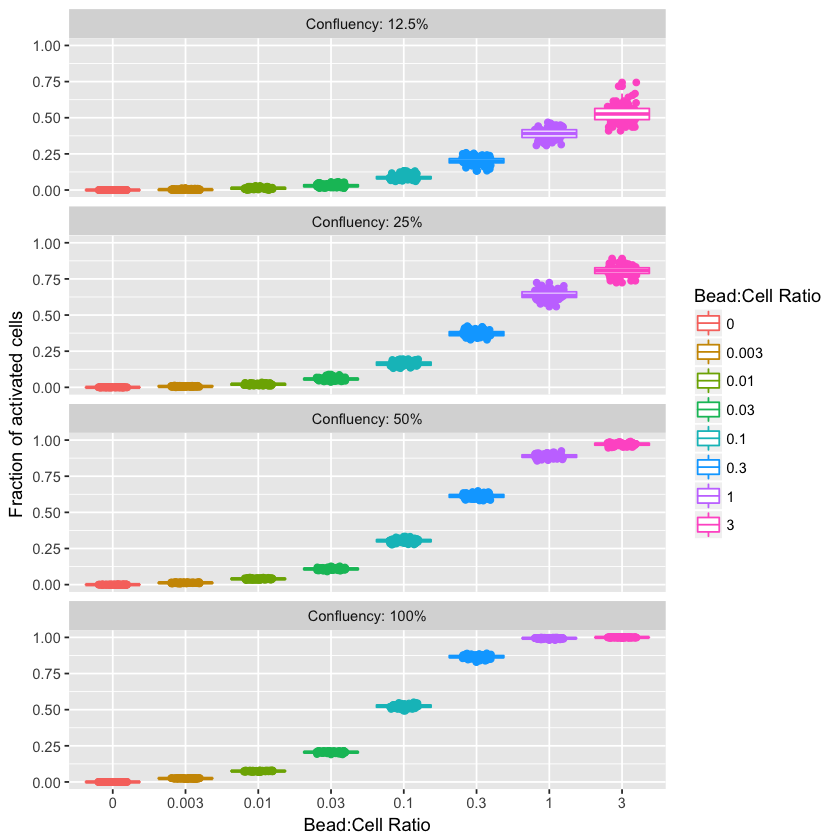

In [14]:
confluency_labeller <- as_labeller(
    c(
        `0.125`="Confluency: 12.5%",
        `0.25`="Confluency: 25%",
        `0.5`="Confluency: 50%",
        `1`="Confluency: 100%"
    )
)

results %>%
    ggplot(aes(x=`Bead_to_cell`, y=`Ratio_Activated`, color=`Bead_to_cell`)) +
    geom_jitter(width=.2) +
    geom_boxplot() +
    facet_wrap(~`Confluency`, nrow=4, labeller="confluency_labeller") +
    ylab('Fraction of activated cells') +
    xlab('Bead:Cell Ratio') +
    scale_color_discrete(name="Bead:Cell Ratio")

This is amazing! One thing that is apparent from this experiment is that the efficiency of activation, as defined by the fraction of cells that are activated, depends on both the bead:cell ratio and the confluency. At a higher confluency, a cell ending up near a bead is much more likely hence even with fewer bead (0.3), we almost always get ~90% activation. As the confluency goes down, the efficiency also goes down so for example, using 3 beads to 1 cell at 25% confluency can barely activate 75%. 

And moreover, we get that nice sigmoid curve that we got from actual experiments, meaning that this type of modeling seems to capture at least the basics. The real world confluency might need to be adjusted to correspond well with the virtual confluency but that is alright.

## The effect of activation efficiency on the overall T cell yield
For clinics, the most critical part of ex vivo T cell expansion is to get a fixed number of cells fast and reliably. This goal is usually defined on the orders of hundreds of millions of T cells, which requires at least two-wekk ex vivo expansion. 

It is great that we can estimate the fraction of T cells activated for a given condition, but how different a 70% activation would look after two weeks compared to 100%? Do we even have the capabilities of capturing such differences? At what point, do we start seeing considerable differences in the total number of T cells? Let's explore this.

The final yield is usually calculated by counting the number of cells within the culture and is usually approximated from a portion of the culture using a cell counter and assuming a uniform population. To see the error margins on a typical counter machine, we counted the number of cells within a single sample for 10 times:

In [15]:
replicate_counts <- read_tsv('counts.tsv')
replicate_counts

Live cells per mL,Live fraction,Cellular size
2340000,0.85,13.04
2180000,0.84,12.70
2280000,0.84,13.11
1980000,0.81,12.81
2370000,0.85,12.99
2330000,0.83,13.69
2110000,0.81,13.22
2640000,0.83,13.08
2130000,0.80,13.26
2010000,0.74,13.20


As can be seen from the table above, the estimated number can vary a bit. Let's get the average, standard deviation, and using these, calculate a 95% confidence level (+/-1.96 times standard deviation):

In [16]:
counter_summary <- 
    replicate_counts %>%
    summarize(
        `Average_count`=mean(`Live cells per mL`),
        `Std_count`=sd(`Live cells per mL`),
        `confidence_radius`=(1e6/`Average_count`)*`Std_count`*1.96 # .95% confidence
    )

counter_summary

Average_count,Std_count,confidence_radius
2237000,197092.8,172687.4


So our cell counter can be wrong by 170K cells per 1 million.

For convenience, let's assume that we will seed 1 million cells for each condition and start gorowing them for a while (10 replications). We will assume that, once a cell is activated it will divide at each replication point and stay activated (so 1 activated cells will give 4 cells after 2 replications). 

For simplity, let's also assume that we are working at a 50% confluency, which is very close to our working concentration. Let's extract the summary statistics first:

In [17]:
n_seed_cells <- 1e6
n_replication <- 10
counting_error_per_million <- counter_summary$`confidence_radius`/1e6

conf_results <-
    sum_results %>%
    filter(`Confluency` == '0.5')

conf_results

Confluency,Bead_to_cell,Avg_Ratio_Activated,StdDev_Ratio_Activated
0.5,0,0.00000,0.000000000
0.5,0.003,0.01244,0.002463142
0.5,0.01,0.03981,0.004076776
0.5,0.03,0.10865,0.006376052
0.5,0.1,0.30314,0.011287805
0.5,0.3,0.61348,0.014500073
0.5,1,0.88938,0.013160839
0.5,3,0.97048,0.009310014


Now, we will simulate this population for a total of 10 replications and calculate the total number of cells we end up with and how confidently we could capture the differences:

In [18]:
projected_counts <- tibble(
    `Activated fraction`=rep(conf_results$Avg_Ratio_Activated, n_replication),
    `Bead_to_cell`=rep(conf_results$Bead_to_cell, n_replication),
    `Seed_count`=`Activated fraction` * 1e6,
    `Days`=1:n_replication %>% lapply(FUN=function(x) { rep(x, nrow(conf_results)) }) %>% unlist,
    `Count`=(`Seed_count` * (2 ** `Days`)) + (n_seed_cells * (1 - `Activated fraction`)),
    `Estimated_cultute_volume`=as.integer(`Count` / 1e6),
    `Assumed_counting_error`=(`Estimated_cultute_volume` * counting_error_per_million * 1e6),
    `Count_minus_error`=`Count`-`Assumed_counting_error`,
    `Count_plus_error`=`Count`+`Assumed_counting_error`
) %>%
mutate(
    `Activated fraction`=factor(`Activated fraction`),
    `Days`=factor(`Days`)
)

projected_counts %>% head(n=20)

Activated fraction,Bead_to_cell,Seed_count,Days,Count,Estimated_cultute_volume,Assumed_counting_error,Count_minus_error,Count_plus_error
0,0,0,1,1000000,1,172687.4,827312.6,1172687
0.01244,0.003,12440,1,1012440,1,172687.4,839752.6,1185127
0.03981,0.01,39810,1,1039810,1,172687.4,867122.6,1212497
0.10865,0.03,108650,1,1108650,1,172687.4,935962.6,1281337
0.30314,0.1,303140,1,1303140,1,172687.4,1130452.6,1475827
0.61348,0.3,613480,1,1613480,1,172687.4,1440792.6,1786167
0.88938,1,889380,1,1889380,1,172687.4,1716692.6,2062067
0.97048,3,970480,1,1970480,1,172687.4,1797792.6,2143167
0,0,0,2,1000000,1,172687.4,827312.6,1172687
0.01244,0.003,12440,2,1037320,1,172687.4,864632.6,1210007


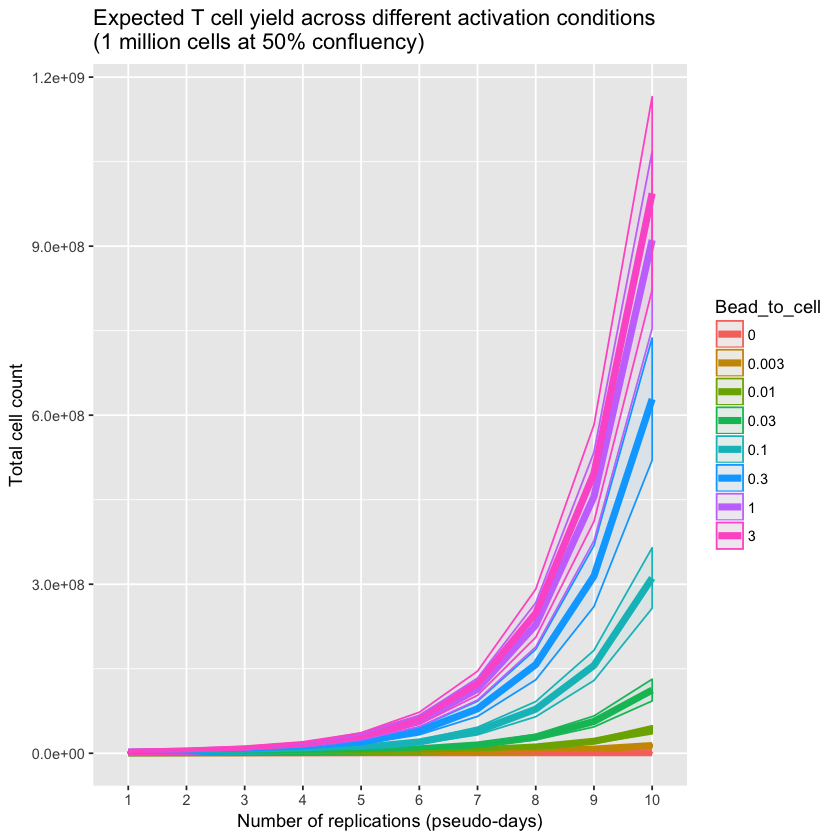

In [19]:
projected_counts %>%
    ggplot(aes(x=`Days`, y=`Count`, color=`Bead_to_cell`, group=`Bead_to_cell`)) +
    geom_line(size=2) +
    geom_ribbon(
        aes(
            ymin=`Count_minus_error`,
            ymax=`Count_plus_error`,
            fill=`Bead_to_cell`
        ),
        alpha=0.05
    ) +
    ylab('Total cell count') +
    xlab('Number of replications (pseudo-days)') +
    ggtitle('Expected T cell yield across different activation conditions\n(1 million cells at 50% confluency)')


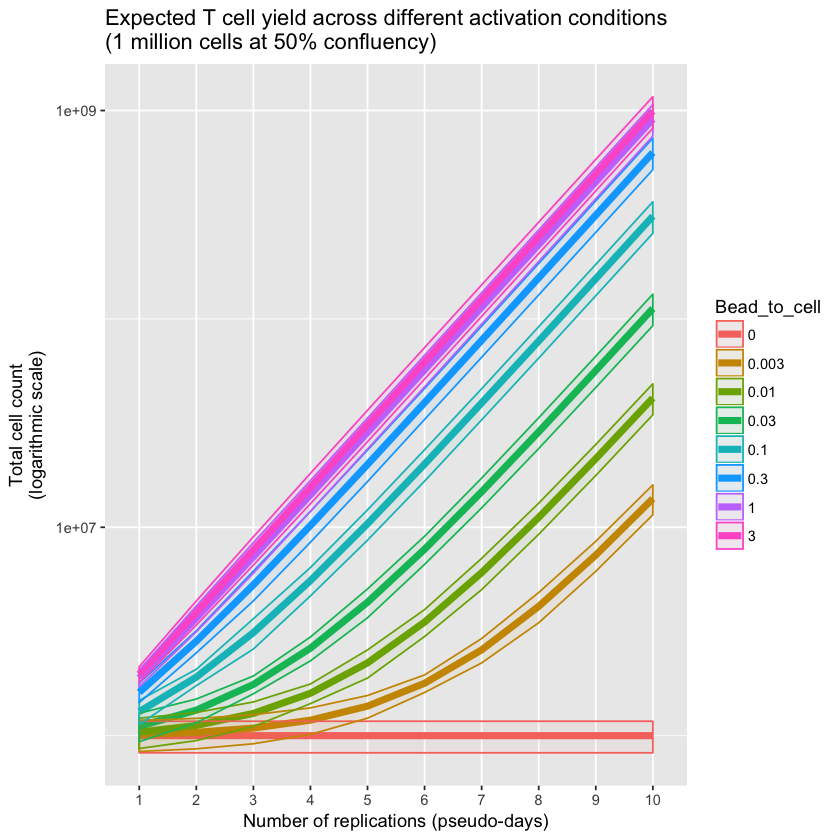

In [20]:
projected_counts %>%
    ggplot(aes(x=`Days`, y=`Count`, color=`Bead_to_cell`, group=`Bead_to_cell`)) +
    geom_line(size=2) +
    geom_ribbon(
        aes(
            ymin=`Count_minus_error`,
            ymax=`Count_plus_error`,
            fill=`Bead_to_cell`
        ),
        alpha=0.05
    ) +
    ylab('Total cell count\n(logarithmic scale)') +
    xlab('Number of replications (pseudo-days)') +
    ggtitle('Expected T cell yield across different activation conditions\n(1 million cells at 50% confluency)') +
    scale_y_log10()


The plots above show the total number of T cells we have for each time point for various bead to cell ratios. For each growth curve, we have a confidence interval around it showing it how sensitive we are when estimating the total number of cells at that level.

As can be seen from both the normal and the logarithmic scales, at 50% confluency, there is really not much of a "detectable" difference across the yields we expect to get across `3`, `1`, or `0.3` ratios. At this level, even the yield from a `0.01` bead to cell ratio could be considered acceptable.

## Simulating flow cytometry results
Up until so far, we assumed that all cells that we have in the culture could be activated but in reality, this is not the case. Depending on the donor, an unstimulated cell population can have varying frequencies of `Naive`, `Central Memory`, `Effector Memory`, or `EMRA` cells. For example, from: [T cell subset variance across donors](https://github.com/hammerlab/t-cell-guide/blob/master/analyses/tsubset-prevalence/T%20cell%20subset%20variance%20across%20donors.ipynb):


<a href="https://cl.ly/b05aebcc3acb" target="_blank"><img src="https://d2ddoduugvun08.cloudfront.net/items/1u0t3j3c07381O2i2813/Image%202019-01-09%20at%203.32.55%20PM.png" style="display: block;"/></a>

`EM` and `EMRA` populations do not get activated or even if they get activated, they don't proliferate as fast as `CM` ones. The main population that drives the ex vivo expansion is the activated naive population. A naive cell, once activated, will turn into `CM` and keep proliferating as long as the culture conditions are allowing and usually these freshly minted `CM`s and re-activated `CM`s end up dominating the culture as the other populations don't proliferate. 

Given that we know the fraction of cells that we can activate for a given activation condition, we can now simulate how things would look if we were to run our sample through flow cytometry at different time points. We distinguish between different classes of T cells via using a combination of `CCR7` and `CD45RO` staining:

- `Naive`: CCR7+ CD45RO-
- `CM`:    CCR7+ CD45RO+
- `EM`:    CCR7- CD45RO+
- `EMRA`:  CCR7- CD45RO-

Here are a few different donor profiles:

<a href="https://cl.ly/7aef87695333" target="_blank"><img src="https://d2ddoduugvun08.cloudfront.net/items/463l1r2J1P410T292D1I/Image%202018-12-21%20at%205.36.19%20PM.png" style="display: block;height: auto;width: 100%;"/></a>

Using some log-normal distributions, this is not so hard to simulate. Let's asssume we have a virtual donor with the following baseline profile:

- `Naive`: 43%
- `CM`:    29%
- `EM`:    21%
- `EMRA`:   7%

and simulate a flow run with 10K events in it:

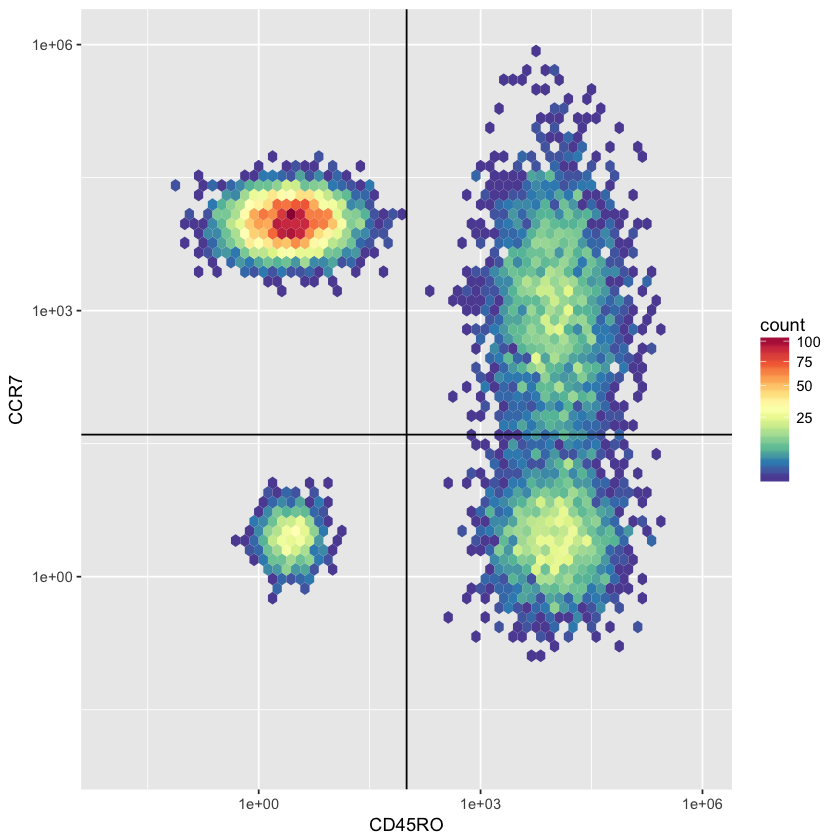

In [21]:
# Red (dense) -> Blue (sparse)
flow_colors <- rev(RColorBrewer::brewer.pal(11, "Spectral"))

generate_flow_data <- function(frac_naive, frac_cm, frac_em, frac_emra, n_events=1e4) {
    positive_mean <- log(10 ** 4)

    ccr7_positive <- c(`mean`=positive_mean, `sdlog`=.5)
    ccr7_negative <- c(`mean`=1, `sdlog`=.5)

    cd45ro_positive <- c(`mean`=positive_mean, `sdlog`=1)
    cd45ro_negative <- c(`mean`=1, `sdlog`=.5)

    flow_naive <- tibble(
        `CCR7`=rlnorm(n_events * frac_naive, mean=ccr7_positive['mean'], sdlog=ccr7_positive['sdlog']),
        `CD45RO`=rlnorm(n_events * frac_naive, mean=cd45ro_negative['mean'], sdlog=cd45ro_negative['sdlog']*2)
    )

    flow_cm <- tibble(
        `CCR7`=rlnorm(n_events * frac_cm, mean=log(10 ** 3), sdlog=ccr7_positive['sdlog']*4),
        `CD45RO`=rlnorm(n_events * frac_cm, mean=cd45ro_positive['mean'], sdlog=cd45ro_positive['sdlog'])
    )

    flow_em <- tibble(
        `CCR7`=rlnorm(n_events * frac_em, mean=ccr7_negative['mean'], sdlog=ccr7_negative['sdlog']*2),
        `CD45RO`=rlnorm(n_events * frac_em, mean=cd45ro_positive['mean'], sdlog=cd45ro_positive['sdlog'])
    )

    flow_emra <- tibble(
        `CCR7`=rlnorm(n_events * frac_emra, mean=ccr7_negative['mean'], sdlog=ccr7_negative['sdlog']),
        `CD45RO`=rlnorm(n_events * frac_emra, mean=cd45ro_negative['mean'], sdlog=cd45ro_negative['sdlog'])
    )

    flow_data <- rbind(
        flow_naive,
        flow_cm,
        flow_em,
        flow_emra
    )
    
    return(flow_data)
}

# Made up numbers based on what we see on average
frac_naive <- .43
frac_cm <- .29
frac_em <- .21
frac_emra <- .07

generate_flow_data(
    frac_naive=frac_naive,
    frac_cm=frac_cm,
    frac_em=frac_em,
    frac_emra=frac_emra
) %>%
    ggplot(aes(x=`CD45RO`, y=`CCR7`)) +
    stat_binhex(bins=64) +
    geom_hline(yintercept=40) + # Arbitrary threshodls
    geom_vline(xintercept=100) +
    scale_x_log10(limits=c(0.01, 1e6)) +
    scale_y_log10(limits=c(0.01, 1e6)) +
    scale_fill_gradientn(colours=flow_colors, trans="sqrt")

Can't fool a hard-core immunologist with this but this level of detaiils will serve us well. All right -- so this is how our virtual donor's baseline profile looks like. Now, we would like to see how this cytometric profile changes over time. For this, we will evolve the population as such:

- an activated naive cell will divide and become two CMs;
- a freshly-minted CM or a re-activated CM will double at each replication point;
- Unactivated cells (fraction of naive and CM together with all EMs and EMRAs),
  - don't die;
  - don't change subtype;
  - don't divide.
  
With these rules in hand, we will now simulate different numbers of replications and see how the fraction and the absolute number of cells change over time fir different activation conditions: 3, 1, 0.1, 0.01, 0. To not make things over-crowded, we will focus on a few days (replications 2, 4, and 8) for the simulated flow cytometry data.

In [22]:
all_counts <-
    projected_counts %>%
    select(`Activated fraction`, `Bead_to_cell`, `Seed_count`, `Days`, `Count`) %>%
    mutate(
        `num_act_frac`=as.numeric(as.character(`Activated fraction`)),
        `num_days`=as.numeric(as.character(`Days`)),
        `act_naive`=(n_seed_cells * frac_naive) * num_act_frac,
        `act_cm`=(n_seed_cells * frac_cm) * num_act_frac,
        `n_naive`=(n_seed_cells * frac_naive) - `act_naive`,
        `n_cm`=(n_seed_cells * frac_cm) + (`act_naive` * (2 ** num_days)) + (`act_cm` * (2 ** num_days)),
        `n_em`=n_seed_cells * frac_em,
        `n_emra`=n_seed_cells * frac_emra,
        `total`=`n_naive` + `n_cm` + `n_em` + `n_emra`,
        `f_naive`=`n_naive`/`total`,
        `f_cm`=`n_cm`/`total`,
        `f_em`=`n_em`/`total`,
        `f_emra`=`n_emra`/`total`
    )

selected_counts <-
    all_counts %>%
    filter(
        `num_days` %in% c(2, 4, 8),
        `Bead_to_cell` %in% c("3", "1", "0.1", "0.01", "0")
    )

flow_all <- c(NULL)
for(i in 1:nrow(selected_counts)) {
    flow_data <- generate_flow_data(
        frac_naive=selected_counts$`f_naive`[i],
        frac_cm=selected_counts$`f_cm`[i],
        frac_em=selected_counts$`f_em`[i],
        frac_emra=selected_counts$`f_emra`[i]
    )
    
    flow_data$`Bead_to_cell` <- selected_counts$`Bead_to_cell`[i]
    flow_data$`Days` <- selected_counts$`Days`[i]
    flow_all %<>% rbind(flow_data)
}

head(flow_all)

CCR7,CD45RO,Bead_to_cell,Days
10751.922,2.775391,0,2
14843.148,7.292578,0,2
21813.219,2.854134,0,2
10019.284,3.261179,0,2
8497.782,5.567801,0,2
7673.955,5.016690,0,2


Warning message:
“Removed 30 rows containing non-finite values (stat_binhex).”Warning message:
“Removed 2 rows containing missing values (geom_hex).”

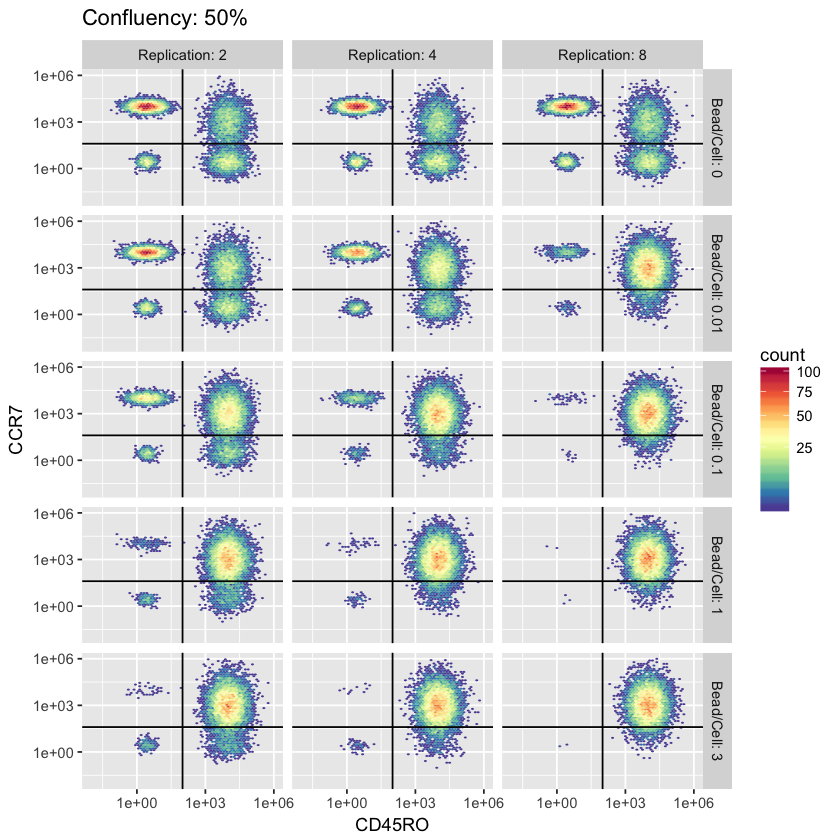

In [23]:
flow_all %>%
    mutate(
        `Bead_to_cell`=paste("Bead/Cell:", `Bead_to_cell`),
        `Days`=paste("Replication:", `Days`)
    ) %>%
    ggplot(aes(x=`CD45RO`, y=`CCR7`)) +
        stat_binhex(bins=64) +
        geom_hline(yintercept=40) +
        geom_vline(xintercept=100) +
        scale_x_log10(limits=c(0.01, 1e6)) +
        scale_y_log10(limits=c(0.01, 1e6)) +
        scale_fill_gradientn(colours=flow_colors, trans="sqrt") +
        facet_grid(`Bead_to_cell` ~ `Days`) +
        ggtitle('Confluency: 50%')

We can see that CM population tends to dominate an activated population even at really low-efficiency activation conditions (see bead:cell of 0.01 at replication 8). When the activation is not efficienct, though, the population might falsely reflect itself as if it is 'diverse' with different groups of populations but this is just an artifact of low-efficiency activation. At one extreeme, for example, the unstimulated population (bead:cell 0) stays as is.

### Sanity check with experimental data
So far so good, but how would these plots look like in real world? Let's repeat this process for a specific donor and compare and contrast. We will focus on Donor 35 and here is this donor on the 4th day of activation with four replicates per each activation condition:

<a href="https://cl.ly/86c5d2c9270a" target="_blank"><img src="https://d2ddoduugvun08.cloudfront.net/items/0J3H062c3z2u3J1V1931/%5B9bdc7b53eaac3c66002cf38c569771ce%5D_Image+2019-01-09+at+10.07.06+AM.png" style="display: block;height: auto;width: 100%;"/></a>

which seems to reflect the overall tendency of more CMs accumulating in the populations that have better activation.


## Focusing on population-level statistics

To an untranied eye, for conditions where we have efficienct activation, it might seem like the population purely consists of CMs but this is misleading. Unactivated naives together with all the EMs and EMRAs are still in the population but due to explonentially growing CM population, they become minorities in the flow cytometric analyses.

This would be more apparent if we plot these frequencies and then the absolute numbers of cells per each replication:

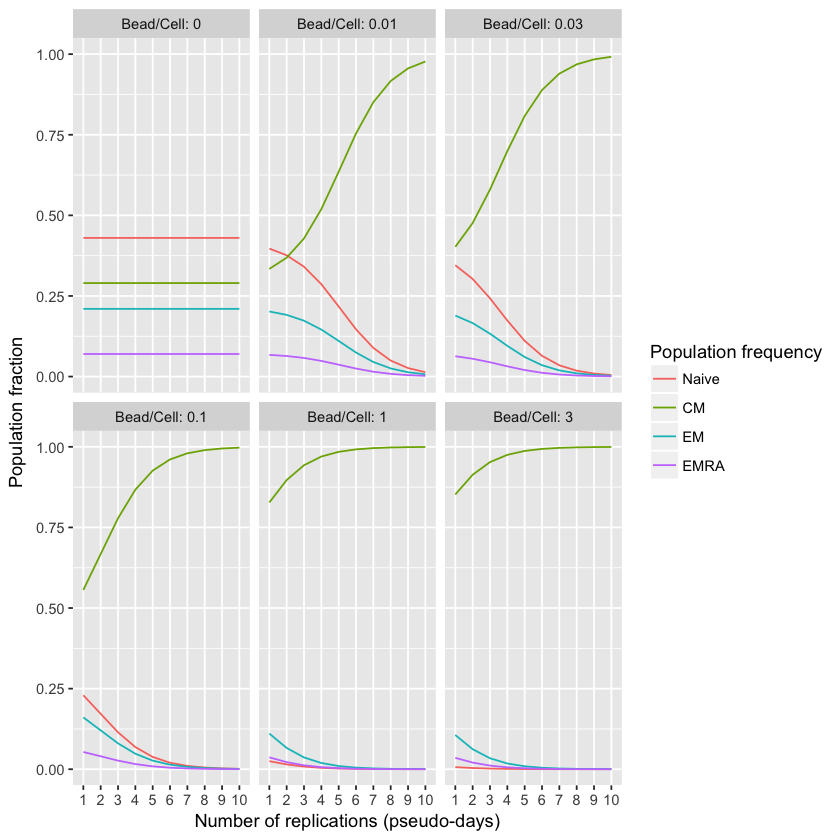

In [24]:
all_counts %>%
    filter(`Bead_to_cell` %in% c("0", "0.01", "0.03", "0.1", "1", "3")) %>%
    gather(
        key='Population frequency',
        value='Population frequency value',
        factor_key=TRUE,
        `f_naive`:`f_emra`
    ) %>%
    mutate(
        `Population frequency`=factor(`Population frequency`, labels=c('Naive', 'CM', 'EM', 'EMRA')),
        `Bead_to_cell`=paste("Bead/Cell:", `Bead_to_cell`)
    ) %>%
    ggplot(aes(x=`Days`, y=`Population frequency value`, color=`Population frequency`)) +
    geom_line(aes(group=`Population frequency`)) +
    facet_wrap(~`Bead_to_cell`) +
    xlab('Number of replications (pseudo-days)') +
    ylab('Population fraction')

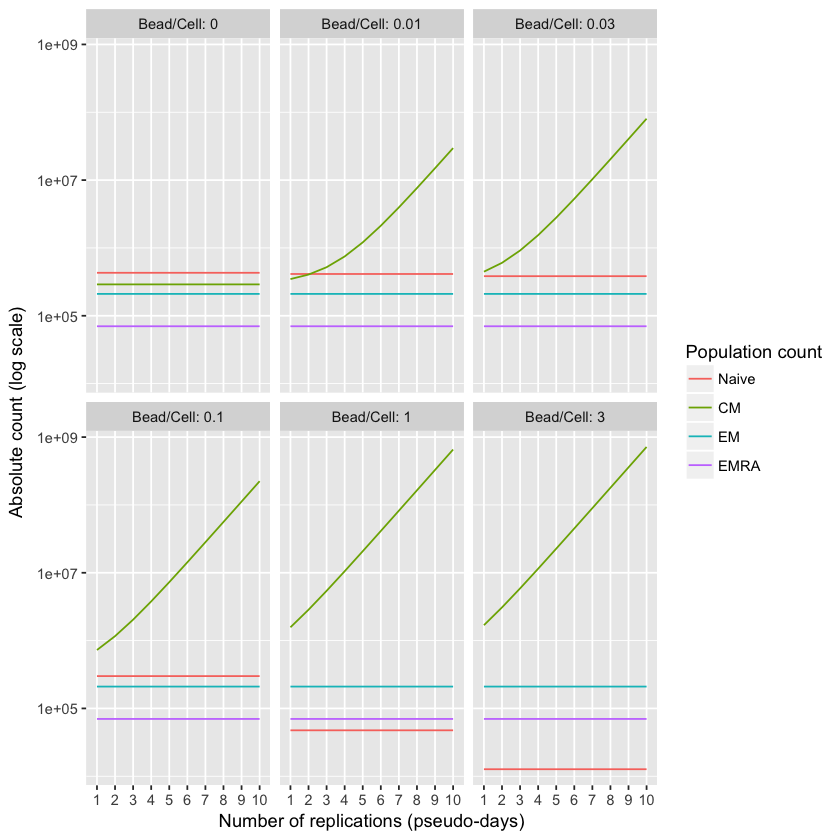

In [25]:
all_counts %>%
    filter(`Bead_to_cell` %in% c("0", "0.01", "0.03", "0.1", "1", "3")) %>%
    gather(
        key='Population count',
        value='Population count value',
        factor_key=TRUE,
        `n_naive`:`n_emra`
    ) %>%
    mutate(
        `Population count value`=`Population count value` + 1,
        `Population count`=factor(`Population count`, labels=c('Naive', 'CM', 'EM', 'EMRA')),
        `Bead_to_cell`=paste("Bead/Cell:", `Bead_to_cell`)
    ) %>%
    ggplot(aes(x=`Days`, y=`Population count value`, color=`Population count`)) +
    geom_line(aes(group=`Population count`)) +
    facet_wrap(~`Bead_to_cell`) +
    scale_y_log10() +
    xlab('Number of replications (pseudo-days)') +
    ylab('Absolute count (log scale)')


# Conclusion